Цель:
В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

Описание/Пошаговая инструкция выполнения домашнего задания:

Часть 1. Парсинг

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

* Сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”)
* Сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной
* Блоги - тексты заметок + число просмотров
* И любые другие ваши идеи, которые подходят под такой формат Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать. Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла) 

Часть 2. NLP

1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик
Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). 
5. Проинтерпретируйте результаты. P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь, главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

In [2]:
! pip install pymorphy2 catboost shap

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 76.6 MB 50 kB/s 
     |████████████████████████████████| 564 kB 47.9 MB/s 
     |████████████████████████████████| 8.2 MB 29.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from catboost import CatBoostClassifier, Pool
import requests
import bs4
from time import sleep
import urllib
import re
import random
import pymorphy2
import nltk
import seaborn as sns
import shap

## Parsing

Данные собирались с сайта https://shop.tastycoffee.ru/coffee

В датасет входит описание лота(кофе, аксессуар), отзывы по данному лоту и оценка(Понравился, не понравился, нейтральный) 

In [ ]:
url = 'https://shop.tastycoffee.ru/coffee?page={}'
headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
        'Connection': 'keep-alive',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'none',
        'Sec-Fetch-User': '?1',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36',}

hrefs = []
ids_comment = []
descriptions = []
texts_comment = []
scores = []
regex = re.compile('.*impress*.')


def parsing():  
  for i in range(1,1500):
      page = requests.get(url.format(i), headers=headers, proxies=urllib.request.getproxies())
      
      if page.status_code == 200:
        soup = bs4.BeautifulSoup(page.content, "lxml")
        items = soup.find_all('div', attrs={'class': 'nameTovar'})
        # Цикл по всем лотам
        for item in items:
            sleep(random.randrange(0, 2, 2))
            href = item.find('a')['href'] + '?page={}'
          
            # Цикл по всем страницам с комментариями 
            for j in range(1,100):
              sleep(random.randrange(0, 5, 2))
              coffee_page = requests.get(href.format(j), headers=headers, proxies=urllib.request.getproxies())
              if coffee_page.status_code == 200:
                coffe_soup = bs4.BeautifulSoup(coffee_page.content, "lxml")
                
                description_good = coffe_soup.find('p', attrs={'class': 'textGoods'}).text
                comments = coffe_soup.find_all('div', attrs={'class': 'for_comment reviewsBox parent'})
                
                # Комментарии на одной странице
                for comment in comments:
                  id_comment = comment['id'] # id комментария
                  text_comment = comment.find('div', attrs={'class': 'review-text indent'}).text # текст комментария
                  if comment.find('span', attrs={'class': regex}):
                    score = comment.find('span', attrs={'class': regex})['title'] # Оценка (хранится в аватарке пользователя)

                    texts_comment.append(text_comment.strip())
                    ids_comment.append(id_comment)
                    scores.append(score)
                    descriptions.append(description_good)
                    hrefs.append(href)
                # Сохраняем в файл частями 
                pd.DataFrame({'text_comment': texts_comment, 'id_comment': ids_comment, 'desciption': descriptions, 'score':scores, 'href': hrefs}).to_csv('dataset2.csv')
              else:
                break
      else:
        break

## NLP

In [4]:
df = pd.read_csv('coffee_reviews.csv', index_col=0)

In [ ]:
df

,text_comment,id_comment,desciption,score,href
0,Классический вкус :),comment_32951,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/brazil-cerr...
1,Сорт неплохой. Брали пару раз,comment_32948,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/brazil-cerr...
2,Ровная Бразилия. Как для меня - классика. Ниче...,comment_32935,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/brazil-cerr...
3,"Мой первый заказ в Вашем магазине, до этого по...",comment_32905,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/brazil-cerr...
4,Этот сорт всегда использовал как базовый для э...,comment_32889,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/brazil-cerr...
...,...,...,...,...,...
3356,Единственный луч света в последние события! \n...,comment_31956,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/yemen-al-ma...
3357,"Есть кофе из Йемена, а есть весь остальной коф...",comment_31890,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/yemen-al-ma...
3358,Кофе понравился. Приготовила во френч-прессе. ...,comment_32977,\n ...,Понравился,https://shop.tastycoffee.ru/coffee/ethiopia-vo...
3359,"Здравствуйте! Подскажите, пожалуйста, с учетом...",comment_30655,\n ...,Понравился,https://shop.tastycoffee.ru/accessories/gift-b...


Очень сильный перевес в сторону оценки "Понравился"

In [ ]:
df['score'].value_counts()

Понравился       2706
Нейтрально        403
Не понравился     252
Name: score, dtype: int64

In [5]:
df.loc[:, 'y_score'] = 1
df.loc[df['score'] == 'Не понравился', 'y_score'] = -1
df.loc[df['score'] == 'Нейтрально', 'y_score'] = 0

In [ ]:
df['desciption'][0].strip()

'Сбалансированный вкус с нотами жареных орехов, шоколада и карамели'

### Preprocessing

In [6]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

word_tokenizer = nltk.WordPunctTokenizer()
lemma = nltk.WordNetLemmatizer()
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def clean(text: str):
  """Функция для очистки данных от тегов, знаков препинаний,
      стоп-слов, лемматизация и токенизация"""

  text = text.strip() 
  text = re.sub('[^A-Za-zА-Яа-я0-9]+', ' ', text) # Оставляем только буквы и цифры

  tokens = nltk.word_tokenize(text) # Разбиваем на токены

  tokens = [word.lower() for word in tokens] # Нижний регистр
  tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Убираем стоп-слова
  tokens = [lemma.lemmatize(word) for word in tokens] # Лемма
  tokens = [morph.parse(word)[0].normal_form for word in tokens]

  text = ' '.join(tokens) # Собираем в строку

  return text


In [9]:
df.loc[:, 'description_clean'] = df.loc[:, 'desciption'].apply(clean)
df.loc[:, 'comment_clean'] = df.loc[:, 'text_comment'].apply(clean)

In [ ]:
df.loc[:, ['text_comment', 'comment_clean']].head(5)

,text_comment,comment_clean
0,Классический вкус :),классический вкус
1,Сорт неплохой. Брали пару раз,сорт неплохой брать пара
2,Ровная Бразилия. Как для меня - классика. Ниче...,ровный бразилия классика плохой сказать мочь я...
3,"Мой первый заказ в Вашем магазине, до этого по...",первый заказ ваш магазин покупать молотый кофе...
4,Этот сорт всегда использовал как базовый для э...,сорт использовать базовый эспрессо молочный на...


Сбалансируем классы 

In [10]:
df_0 = resample(df.loc[df['y_score'] == 0, :], 
         n_samples = df.loc[df['y_score'] == 1, :].shape[0], 
         random_state=1000)
df_1 = resample(df.loc[df['y_score'] == -1, :], 
         n_samples = df.loc[df['y_score'] == 1, :].shape[0], 
         random_state=1000)



df = pd.concat([df.loc[df['y_score'] == 1, :], df_0, df_1])

In [11]:
df['y_score'].value_counts()

 1    2706
 0    2706
-1    2706
Name: y_score, dtype: int64

### TF-IDF

In [12]:
X, y = df['comment_clean'], df['y_score']

train_text, test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, 
                                                    stratify = y)

In [13]:
vectorizer = TfidfVectorizer(max_features = 200, ngram_range=(1,3)) 
vectorizer.fit(train_text)

TfidfVectorizer(max_features=200, ngram_range=(1, 3))

In [14]:
X_train = vectorizer.fit_transform(train_text)
X_test  = vectorizer.transform(test_text)

## Random-Forest Classifier

In [15]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 10)

clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [16]:
print(pd.Series(pred).value_counts())
print(pd.Series(y_test).value_counts())

 0    1105
-1     798
 1     533
dtype: int64
 1    812
-1    812
 0    812
Name: y_score, dtype: int64


In [17]:
print(pred[2])
print(test_text.iloc[2])

-1
ужасно самый невкусный лот который приобразец полтора год ежемесячный закупка tasty coffee очень любить готовить кофе аэропресса последний приехать партия какой рецепт положительный результат либо ненасыщеность либо сразу завал дикий горечь привкус табачный гарь никакой кислинка сладость купить лот первый заказ вообще заказать


In [18]:
print(classification_report(y_test, pred))
print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}")

              precision    recall  f1-score   support

          -1       0.84      0.82      0.83       812
           0       0.67      0.91      0.77       812
           1       0.93      0.61      0.73       812

    accuracy                           0.78      2436
   macro avg       0.81      0.78      0.78      2436
weighted avg       0.81      0.78      0.78      2436

F1 Score: 0.7784608345879099


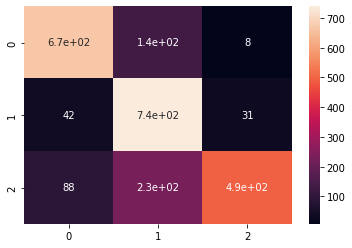

In [19]:
confusion_matrix_table = confusion_matrix(y_test, pred)
sns.heatmap(confusion_matrix_table, annot=True)

## CatBoost

In [20]:
train_pool = Pool(data=X_train, label=y_train, 
                  )
test_pool = Pool(data=X_test, label=y_test, 
                  )


model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='TotalF1', od_type='Iter', 
                               od_wait=500,)
    
model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.060452
0:	learn: 0.4395327	test: 0.4159575	best: 0.4159575 (0)	total: 138ms	remaining: 11m 30s
100:	learn: 0.7422924	test: 0.7178494	best: 0.7178494 (100)	total: 6.44s	remaining: 5m 12s
200:	learn: 0.8320923	test: 0.7919591	best: 0.7936064 (196)	total: 15.5s	remaining: 6m 9s
300:	learn: 0.8818180	test: 0.8421731	best: 0.8421731 (300)	total: 28.8s	remaining: 7m 28s
400:	learn: 0.9162025	test: 0.8707584	best: 0.8707584 (400)	total: 42.5s	remaining: 8m 6s
500:	learn: 0.9284669	test: 0.8812962	best: 0.8835930 (485)	total: 55.2s	remaining: 8m 15s
600:	learn: 0.9384926	test: 0.8904055	best: 0.8908485 (599)	total: 1m 7s	remaining: 8m 12s
700:	learn: 0.9488420	test: 0.8992623	best: 0.9013143 (682)	total: 1m 19s	remaining: 8m 9s
800:	learn: 0.9563757	test: 0.9081006	best: 0.9085261 (796)	total: 1m 30s	remaining: 7m 56s
900:	learn: 0.9613572	test: 0.9134539	best: 0.9134539 (894)	total: 1m 42s	remaining: 7m 44s
1000:	learn: 0.9663593	test: 0.9196724	best: 0.9201094 (991)	to

Качество значительно повысилось

In [21]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))
print(f"F1 Score: {f1_score(y_test, pred, average='weighted')}")

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       812
           0       0.89      0.99      0.93       812
           1       0.99      0.84      0.91       812

    accuracy                           0.94      2436
   macro avg       0.94      0.94      0.94      2436
weighted avg       0.94      0.94      0.94      2436

F1 Score: 0.9383250380725793


Важность признаков

Сразу выделяются признаки, которые дают положительную оценку отзыву. Например: приятный, хороший, понравиться

In [22]:
pd.DataFrame({'feature': vectorizer.get_feature_names(), 'value': model.feature_importances_}).sort_values(['value'], ascending=False).head(15)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,feature,value
14,вкус,3.968262
133,понравиться,3.951500
67,кофе,3.706203
184,хороший,3.687300
114,очень,2.985866
111,отличный,2.459067
143,приятный,2.156281
97,никакой,1.818993
62,кислинка,1.596974
16,вкусный,1.569472


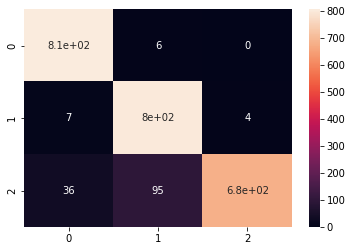

In [23]:
confusion_matrix_table = confusion_matrix(y_test, pred)
sns.heatmap(confusion_matrix_table, annot=True)

In [24]:
shap.initjs()
data = pd.DataFrame(data=X_train.toarray(), columns=vectorizer.get_feature_names())
explainer = shap.TreeExplainer(model)
exp = explainer.shap_values(data)


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Не понравился

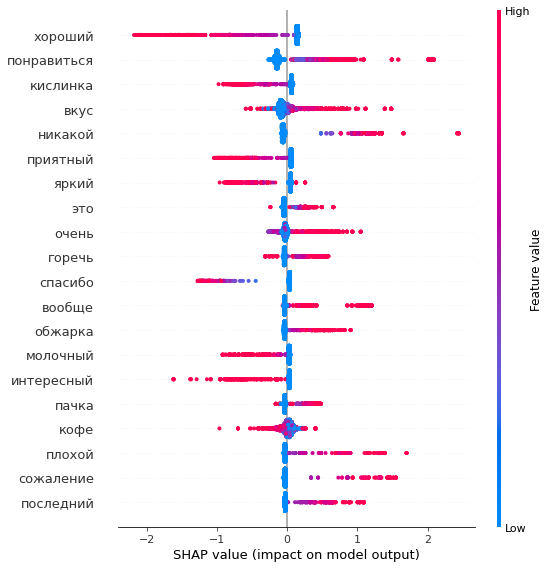

In [25]:
shap.summary_plot(exp[0], data)

Нейтрально

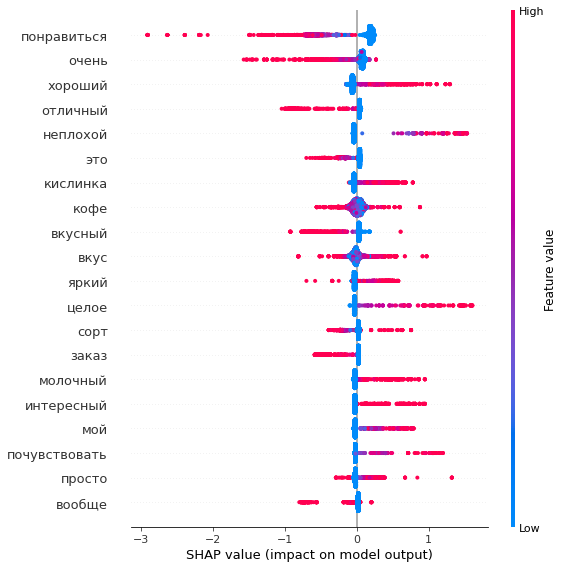

In [26]:
shap.summary_plot(exp[1], data)

Понравился

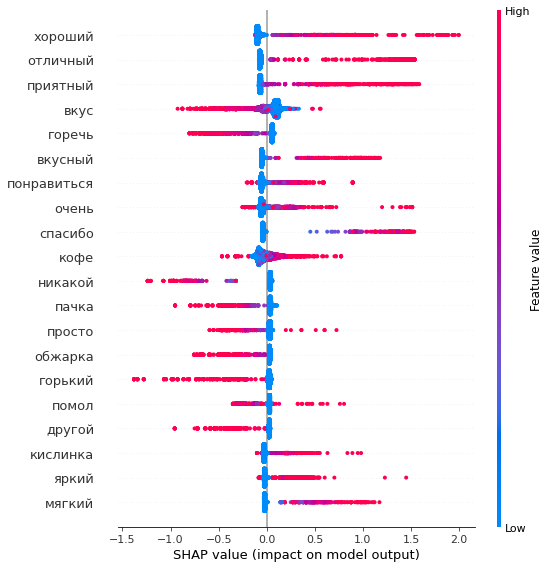

In [27]:
shap.summary_plot(exp[2], data)